<div style="border-radius: 10px; border: #DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size: 100%; text-align: left">
<h3 align="left"><font color='#3498DB'> Chapter9</font></h3>

このノートブックではPyMCでMCMCを実行する方法について紹介しています。  
元のノートブックは以下です。  
https://github.com/pymc-devs/pymc-resources/blob/main/Rethinking_2/Chp_09.ipynb

In [2]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from scipy import stats

warnings.simplefilter(action="ignore", category=FutureWarning)
pd.set_option("mode.chained_assignment", None)

In [3]:
%config Inline.figure_format = 'retina'
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89 
# sets default credible interval used by arviz

In [23]:
num_weeks = int(1e5)
positions = np.zeros(num_weeks)
current =10
for i in range(num_weeks):
    positions[i] = current
    proposal = current + np.random.choice([-1,1])
    if proposal < 1:
        proposal =10
    if proposal > 10:
        proposal =1
    prob_move = proposal / current
    if np.random.uniform() < prob_move:
        current = proposal

<div style="border-radius: 10px; border: #DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size: 95%; text-align: left">
<h3 align="left"><font color='#3498DB'>🦄 Notes: メトロポリスアルゴリズムの例</font></h3>

このコードの背景は教科書を参照してください。
ざっくり言うと、環状に並んだ海上の10個の島の巡り方をコイントスで決めています。
* 一週間が過ぎるごとにforループを回す。
* positions[i] = currentでは現在の位置をpositionに格納している。  
  (iはnum_weeksの数だけある)  
* コイントスによって提案される島の番号はproposalになる。
* ただし、島は環状に順番に並んでいるので、島の番号がマイナスになれば10であり、
  10以上であれば番号1の島に行くことにする。
* 移動確率prob_moveをproposal / currentとして定める。
* prob_moveがランダムな0~1の数値より大きい場合、移動する。

<div style="border-radius: 10px; border: #DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size: 95%; text-align: left">
<h3 align="left"><font color='#3498DB'>🦄 Notes:簡潔なコード</font></h3>

* if文をより簡潔に以下のように書ける。
  ```
   # Wrap around if proposal is out of [1, 10]  
     if proposal < 1: proposal = 10  
     if proposal > 10: proposal = 1
   ```

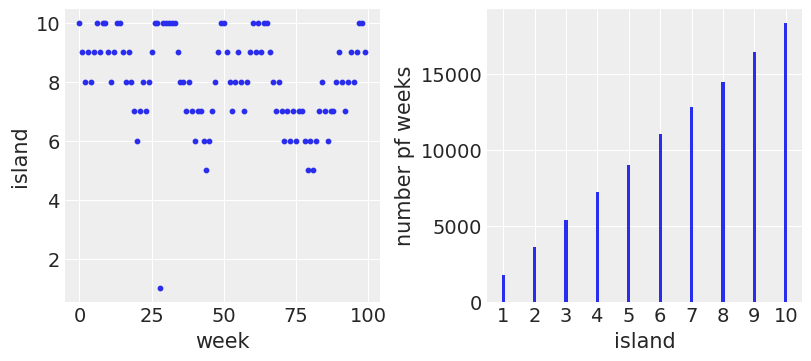

In [55]:
_, axs = plt.subplots(1, 2, figsize=[8, 3.5], constrained_layout=True)

ax0, ax1 = axs

nplot = 100
ax0.scatter(range(nplot), positions[:nplot], s=10)
ax0.set_ylabel("island")
ax0.set_xlabel("week")

counts, _ = np.histogram(positions, bins=10)
ax1.bar(range(10), counts, width=0.1)
ax1.set_ylabel("number pf weeks")
ax1.set_xlabel("island")
ax1.set_xticks(range(10))
ax1.set_xticklabels(range(1, 11));

<div style="border-radius: 10px; border: #DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size: 95%; text-align: left">
<h3 align="left"><font color='#3498DB'>🦄 Notes: 図による表現</font></h3>

* constrained_layout=Trueは自動的な配置を行い、サブプロットが重ならないようにする。
* ax0, ax1 = axs は、axsから取得したサブプロットオブジェクトを ax0 と ax1 にそれぞれ代入する。
* positionsリストの最初の100個をプロットする。
* scatter()の引数のsはデータポイントの点のサイズ。
* _, axs = plt.subplots()とax0, ax1 = axsでアンパック代入を実行している。

Text(0, 0.5, 'Density')

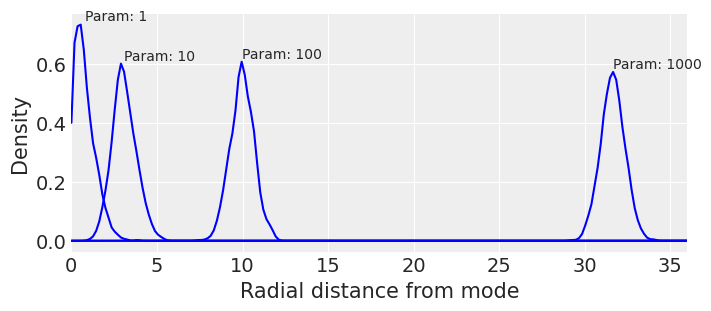

In [58]:
def rad_dist(Y):
    return np.sqrt(np.sum(Y**2))

fig, ax = plt.subplots(1, 1, figsize=[7,3])
xvar = np.linspace(0, 36, 200)

for D in [1, 10, 100, 1000]:
    T = int(1e3)
    Y = stats.multivariate_normal(np.zeros(D), np.identity(D)).rvs(T)
    
    Rd = list(map(rad_dist, Y))

    kde = stats.gaussian_kde(Rd)
    yvar = kde(xvar)
    ax.plot(xvar, yvar, color="b")

    ax.text(np.mean(Rd), np.max(yvar)*1.02, f"Param: {D}")

ax.set_xlim(0, 36)
ax.set_xlabel("Radial distance from mode")
ax.set_ylabel("Density")

<div style="border-radius: 10px; border: #DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size: 95%; text-align: left">
<h3 align="left"><font color='#3498DB'>🦄 Notes: パラメータ数と次元の呪い</font></h3>

* 個々のパラメータを個別のステップでサンプリングする任意のマルコフチェーンは、
  パラメータが多くなると行き詰る。
* パラメータ数が多くなるほどモードはサンプリングしたい値から離れる。
* 横軸が0の点がモード。

In [26]:
def calc_U(x, y, q, a=0, b=1, k=0, d=1):
    muy, mux =q

    U = (
         np.sum(stats.norm.logpdf(y, loc=muy, scale=1))
         + np.sum(stats.norm.logpdf(x, loc=mux, scale=1))
         + stats.norm.logpdf(muy, loc=a, scale=b)
         + stats.norm.logpdf(mux, loc=k, scale=d)
    )

    return -U

In [27]:
# 勾配関数
# Uをqについて偏微分したベクトルが必要

def calc_U_gradient(x, y, q, a=0, b=1, k=0, d=1):
    muy, mux =q

    G1 = np.sum(y - muy) + (a - muy) / b**2  #dU/dmuy
    G2 = np.sum(x - mux) + (k - mux) / b**2  #dU/dmux

    return np.array([-G1, -G2])
    

<div style="border-radius: 10px; border: #DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size: 95%; text-align: left">
<h3 align="left"><font color='#3498DB'>🦄 Notes: no-U-turn サンプラー(NUTS)の実装</font></h3>

* U関数は対数事後確率を表現する
* 勾配関数は偏微分を行う
* リスト[]をNumpy配列に変換

Code 9.7では以下の関数を使用する。

In [36]:
def HMC2(U, grad_U, epsilon, L, current_q, x, y):
    q = current_q  
    p = np.random.normal(loc=0, scale=1, size=len(q))  # ランダムなフリック - pは運動量
    current_p = p
    # 初めに運動量のハーフステップを行う
    p -= epsilon * grad_U(x, y, q) / 2
    # ブックキーピングの初期化 - 経路を保存
    qtraj = np.full((L+1, len(q)), np.nan)
    ptraj = qtraj.copy()
    qtraj[0,:] = current_q
    ptraj[0,:] = p

    # Code 9.9
    # 位置と運動量の交互のフルステップ
    for i in range(L):
        q += epsilon * p #位置のフルステップ
        qtraj[i + 1, :] =q
        # 経路の終わり以外で、運動量のフルステップを行う。
        if i != L - 1:
            p -= epsilon * grad_U(x, y, q)
            ptraj[i + 1, :] = p

    # 終わりに運動量のハーフステップを行う
    p -= epsilon * grad_U(x, y, q) / 2
    ptraj[L, :] = p
    # 提案を対称的にするために、経路の終わりで運動量を負にする
    p *= -1
    # 経路の始まりと終わりでポテンシャルエネルギーと運動エネルギーを評価
    current_U = U(x, y, current_q)
    current_K = np.sum(current_p**2) / 2
    proposed_U = U(x, y, q)
    proposed_K = np.sum(p**2) / 2
    # 経路の終わりの状態を受け入れるか拒否し
    # 経路の終わりの位置または初期位置を返す
    accept = False
    if np.random.uniform() < np.exp(current_U - proposed_U + current_U - proposed_K):
        new_q = q #採択
        accept = True
    else:
        new_q = current_q #棄却
        
    return dict(q=new_q, traj=qtraj, ptraj=ptraj, accept=accept)

<div style="border-radius: 10px; border: #DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size: 95%; text-align: left">
<h3 align="left"><font color='#3498DB'>🦄 Notes: </font></h3>

* qtraj = np.full((L+1, len(q)), np.nan)では、多次元配列 qtraj を生成し、その要素を NaNで初期化している。
* np.full()は、指定された形状と初期値で配列を生成する関数。
* qtraj[0, :] は qtraj 配列の最初の行で、そのすべての列を含む部分配列のこと。
* q += epsilon * pは、q = q + epsilon * pと同じ操作。
* if i != L - 1 は、iがL-1ではない場合のこと。
* p *= -1は、p = p * -1と同じ操作。
* current_p**2は、current_pを2乗する操作のこと。

### Code 9.7

以下コードは、図9.6の上段の両方のパネルを生成するために、コード9.7を拡張したものです。

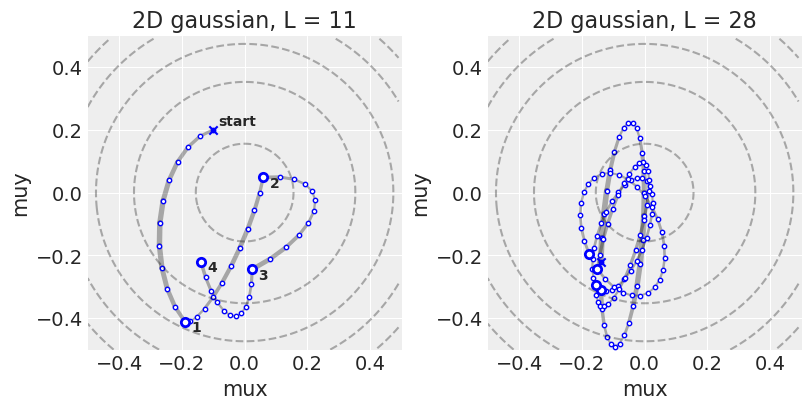

In [59]:
np.random.seed(42)

# テストデータ
real = stats.multivariate_normal([0, 0], np.identity(2))
x, y = real.rvs(50).T

Q = {}
Q["q"] = np.array([-0.1, 0.2])
pr = 0.5
step = 0.03
# L = 11 # Uターン用には0.03 / 28、動作する例では11
n_samples = 4

_, axs = plt.subplots(1, 2, figsize=[8, 6], constrained_layout=True)

for L, ax in zip([11, 28], axs):
    ax.scatter(*Q["q"], color="b", marker="x", zorder=3)
    if L == 11:
        ax.text(*Q["q"] + 0.015, "start", weight="bold")
    for i in range(n_samples):
        Q = HMC2(calc_U, calc_U_gradient, step, L, Q["q"], x, y)
        ax.scatter(*Q["q"], color="w", marker="o", edgecolor="b", lw=2, zorder=3)
        if n_samples < 10:
            for j in range(L):
                KO = np.sum(Q["ptraj"][j, :] **2) /2 # 運動エネルギー
                ax.plot(
                    Q["traj"][j : j + 2, 0],
                    Q["traj"][j : j + 2, 1],
                    color="k",
                    lw=1 + 1 *KO,
                    alpha=0.3,
                    zorder=1,
                )
            ax.scatter(*Q["traj"].T, facecolor="w", edgecolor="b", lw=1, zorder=2, s=10)
            if L ==11:
                ax.text(*Q["q"] + [0.02, -0.03], f"{i+1}", weight="bold")
                        
    ax.set_title(f"2D gaussian, L = {L}")
    ax.set_xlabel("mux")
    ax.set_ylabel("muy")

    #上記で定義された実際の確率に基づいて背景の輪郭線を描画
    ax.set_xlim(-pr, pr)
    ax.set_ylim(-pr, pr)
    xs, ys = np.mgrid[-pr:pr:0.01, -pr:pr:0.01]
    p = real.logpdf(np.vstack([xs.flat, ys.flat]).T).reshape(xs.shape)
    ax.contour(xs, ys, p, 4, colors=[(0,0,0,0.3)])
    ax.set_aspect(1);

<div style="border-radius: 10px; border: #DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size: 95%; text-align: left">
<h3 align="left"><font color='#3498DB'>🦄 Notes: </font></h3>

* {} はPythonの中で辞書を作成するための記法。辞書は、キー（key）とそれに対応する値（value）のペアを格納するデータ構造。  
  (辞書は内部的にハッシュ表(ハッシュテーブル)と呼ばれるリストを持つ。ハッシュ値(その格納先)は重複する可能性もある。)  
  (辞書のキーはハッシュ値を算出可能な型でないといけない(hashable)。)　　
* ax.scatter(*Q["q"], color="b", marker="x", zorder=3)は、ax.scatter(Q["q"][0], Q["q"][1], color="b", marker="x", zorder=3)と同じ。

「相関のある場合は、教科書の内容と比べると、無相関の場合ほどにはうまく機能しないようです。教科書に示されている正弦波の経路を再現していないため、尤度関数にいくつかの根本的な変更があった可能性があるのかもしれません。教科書はこれらのプロットを再現するために使用されたコードやパラメータを提供していないので、私たちはここで推測をしています。」

In [4]:
d = pd.read_csv("rugged.csv", delimiter=";")
d["log_gdp"] = np.log(d["rgdppc_2000"])

dd = d.dropna(subset=["log_gdp"])
dd["log_gdp_std"] = dd["log_gdp"]/ dd["log_gdp"].mean()
dd["rugged_std"] = dd["rugged"] / dd["rugged"].max()

「コード9.12から9.18までについては、  
PyMCを使用して、すでにすべての作業を行っています（No-Uturnサンプリング、並列処理）。

summaryの結果をrethinkingのprecisに変換します。：

* n_eff = ess_mean
* Rhat4 = r_hat

In [5]:
cid = pd.Categorical(dd["cont_africa"])

with pm.Model () as m_8_3:
    a = pm.Normal("a", 1, 0.2, shape=cid.categories.size)
    b = pm.Normal("b", 0, 0.3, shape=cid.categories.size)

    mu = a[np.array(cid)] + b[np.array(cid)] * (dd["rugged_std"].values - 0.215)
    sigma = pm.Exponential("sigma", 1)

    log_gdp_std = pm.Normal("log_gdp_std", mu, sigma, observed=dd["log_gdp_std"].values)

    m_8_3_trace = pm.sample()

az.summary(m_8_3_trace, kind="all", round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],1.05,0.01,1.04,1.07,0.0,0.0,6220.48,3133.96,1.0
a[1],0.88,0.02,0.86,0.91,0.0,0.0,6269.35,3518.50,1.0
b[0],-0.14,0.06,-0.24,-0.05,0.0,0.0,6305.60,3711.69,1.0
b[1],0.13,0.08,0.00,0.24,0.0,0.0,4860.38,3156.66,1.0
sigma,0.11,0.01,0.10,0.12,0.0,0.0,4912.80,3248.66,1.0


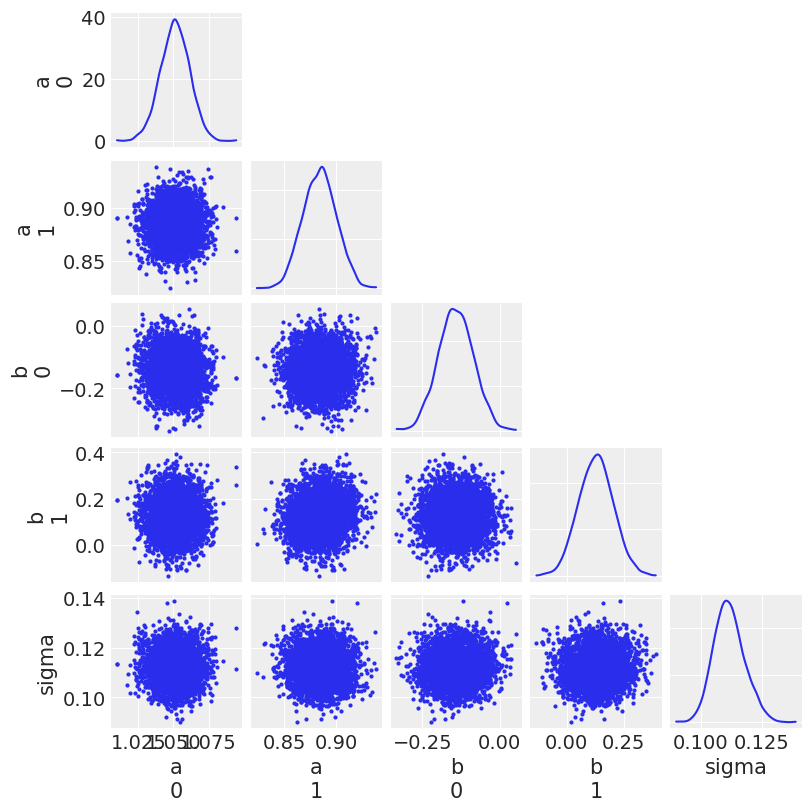

In [6]:
az.plot_pair(m_8_3_trace, figsize=[8, 8], marginals=True);

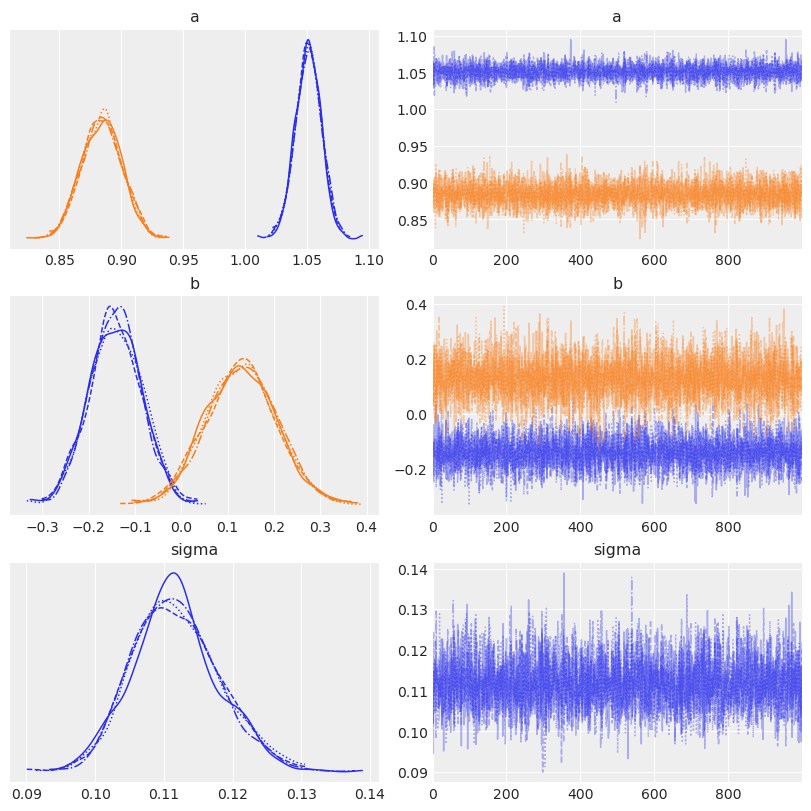

In [8]:
az.plot_trace(m_8_3_trace, figsize=[8, 8]);

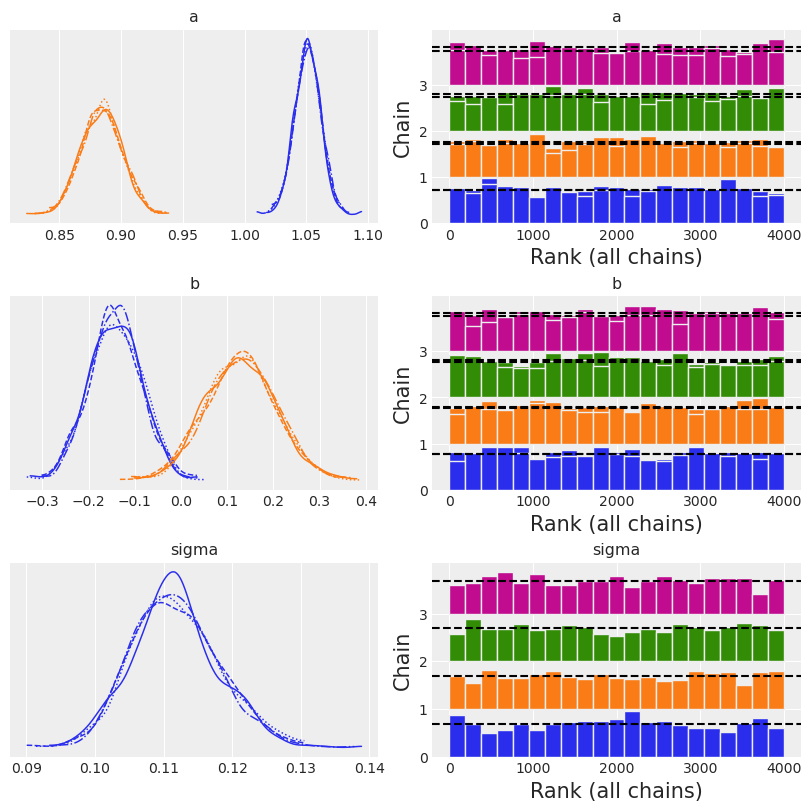

In [10]:
az.plot_trace(m_8_3_trace, figsize=[8, 8], kind="rank_bars");

In [12]:
y = np.array([-1, 1])

with pm.Model() as m_9_2:
    alpha = pm.Normal("alpha", 0, 1000)

    mu = alpha 
    sigma = pm.Exponential("sigma", 0.0001)

    yp = pm.Normal("y", mu, sigma, observed=y)

    m_9_2_trace = pm.sample(chains=3)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [alpha, sigma]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 33 seconds.


In [13]:
az.summary(m_9_2_trace, round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,2.21,377.70,-580.83,582.85,15.87,13.78,683.41,534.56,1.02
sigma,710.67,1383.85,19.37,1663.38,67.59,47.83,60.45,34.81,1.04


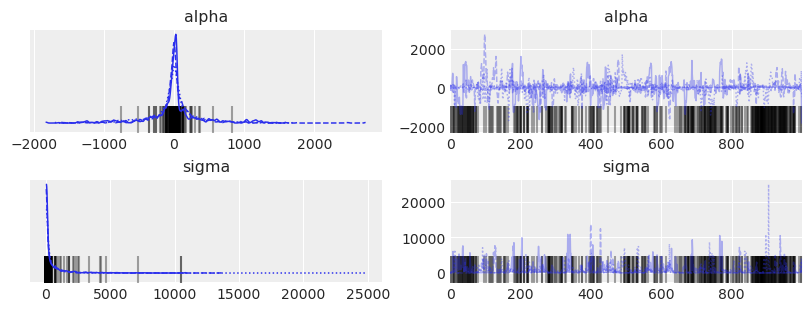

In [20]:
# FIg 9.9(上図)
az.plot_trace(m_9_2_trace, figsize=[8, 3]);

In [19]:
with pm.Model() as m_9_3:
    alpha = pm.Normal("alpha", 1, 10)

    mu = alpha
    sigma = pm.Exponential("sigma", 1)

    yp = pm.Normal("y", mu, sigma, observed=y)

    m_9_3_trace = pm.sample(chains=3)

az.summary(m_9_3_trace, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [alpha, sigma]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 33 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.06,1.29,-1.66,1.88,0.05,0.05,938.23,589.18,1.0
sigma,1.55,0.87,0.45,2.55,0.03,0.02,632.59,702.12,1.0


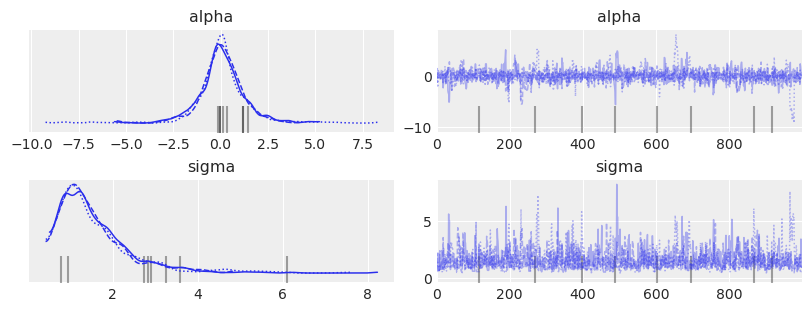

In [22]:
# Fig 9.9 (下図)
az.plot_trace(m_9_3_trace, figsize=[8, 3]);

Sampling: [alpha, sigma]


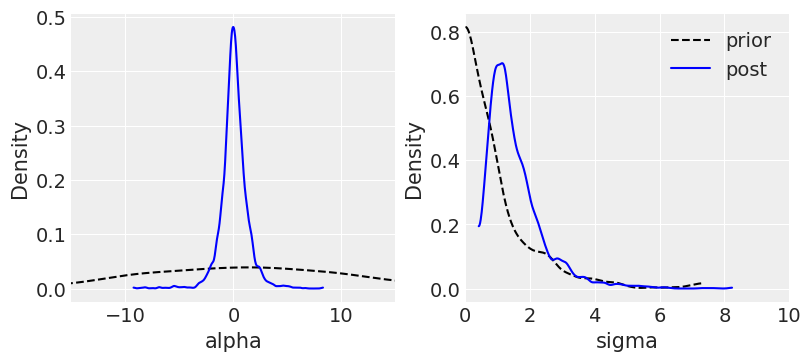

In [25]:
# Fig 9.10
with m_9_3:
    m_9_3_prior = az.extract_dataset(
        pm.sample_prior_predictive(var_names=["alpha", "sigma"])["prior"]
    )
    m_9_3_post = az.extract_dataset(m_9_3_trace["posterior"], var_names=["alpha", "sigma"])

_, axs = plt.subplots(1, 2, figsize=[8, 3.5], constrained_layout=True)
ax0, ax1 = axs

az.plot_kde(
    m_9_3_prior["alpha"].to_numpy(), 
    ax=ax0, 
    plot_kwargs={"color":"k", "ls":"dashed"}
)

az.plot_kde(
    m_9_3_post["alpha"].to_numpy(), 
    ax=ax0, 
    plot_kwargs={"color":"b"}
)

ax0.set_xlim(-15, 15)
ax0.set_xlabel("alpha")

az.plot_kde(
    m_9_3_prior["sigma"].to_numpy(),
    ax=ax1,
    plot_kwargs={"color": "k", "ls":"dashed"},
    label="prior",
)

az.plot_kde(
    m_9_3_post["sigma"].to_numpy(), 
    ax=ax1, 
    plot_kwargs={"color":"b"},
    label="post",
)


ax1.legend()
ax1.set_xlim(0, 10)
ax1.set_xlabel("sigma")

for ax in axs:
    ax.set_ylabel("Density")

In [32]:
y = np.random.normal(loc=0, scale=1, size=100)

In [33]:
with pm.Model() as m_9_4:
    a1 = pm.Normal("a1", 0, 1000)
    a2 = pm.Normal("a2", 0, 1000)

    mu = a1 + a2
    sigma = pm.Exponential("sigma", 1)

    yp = pm.Normal("y", mu, sigma, observed=y)

    m_9_4_trace = pm.sample(chains=3)

az.summary(m_9_4_trace, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [a1, a2, sigma]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 499 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a1,-188.92,650.39,-1185.19,766.85,338.33,261.16,3.95,25.04,2.11
a2,188.98,650.39,-766.84,1185.33,338.33,261.16,3.95,25.04,2.11
sigma,1.09,0.08,0.96,1.20,0.01,0.01,43.45,56.89,1.07


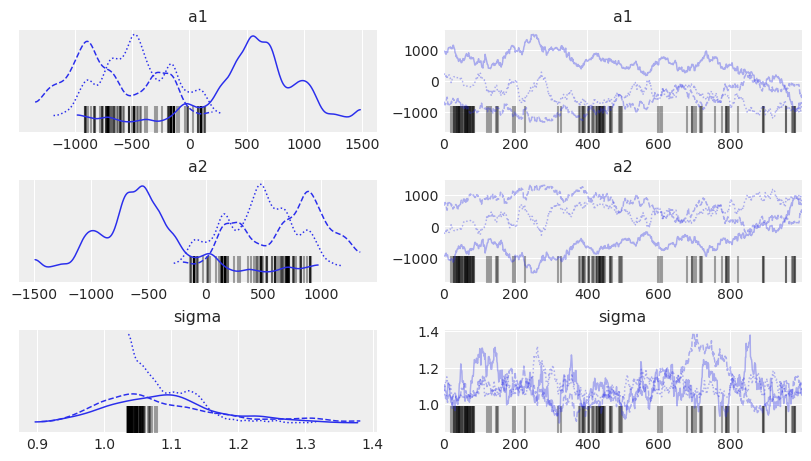

In [34]:
# Fig 9.11(上図)
az.plot_trace(m_9_4_trace, figsize=[8, 4.5]);

In [35]:
with pm.Model() as m_9_5:
    a1 = pm.Normal("a1", 0, 10)
    a2 = pm.Normal("a2", 0, 10)

    mu = a1 + a2
    sigma = pm.Exponential("sigma", 1)

    yp = pm.Normal("y", mu, sigma, observed=y)

    m_9_5_trace = pm.sample(chains=3)

az.summary(m_9_5_trace, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [a1, a2, sigma]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 127 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a1,0.14,6.92,-11.14,10.69,0.23,0.16,931.79,1449.97,1.01
a2,-0.08,6.93,-10.59,11.28,0.23,0.16,933.64,1445.26,1.01
sigma,1.06,0.07,0.94,1.18,0.00,0.00,1244.61,1189.69,1.00


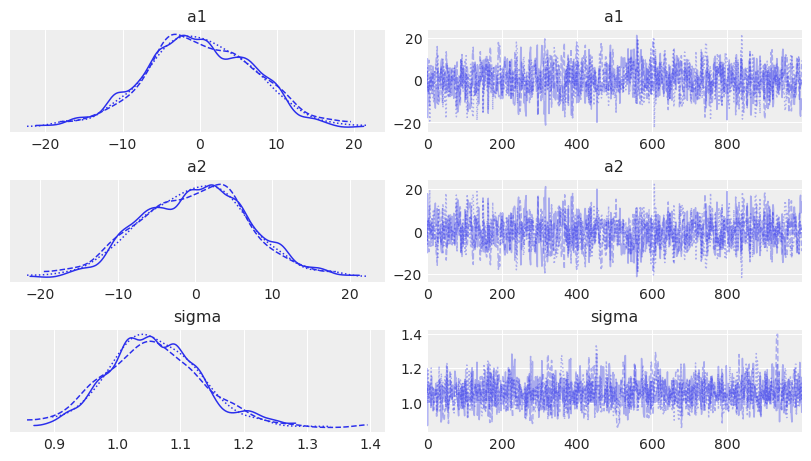

In [36]:
# Fig 9.11　(下図)
az.plot_trace(m_9_5_trace, figsize=[8, 4.5]);